In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from time import time
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torchvision import transforms 
from torchvision import datasets

In [3]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.FloatTensor(x)
    self.y = torch.FloatTensor(y)
  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [4]:
class Data:
    def __init__(self, config):
        self.normal_num = config['normal_num']
        if config['experiment_num'] == 1 or config['experiment_num'] == 3:
            self.ratio = 0.1
        elif config['experiment_num'] == 2 or config['experiment_num'] == 4:
            self.ratio = 0.01
        self.train_x, self.train_y, self.test_x, self.test_y = self.load_data(config['experiment_num'])
        self.train_dataset = dataset(self.train_x, self.train_y)
        self.test_dataset = dataset(self.test_x, self.test_y)

    def load_data(self, experiment_num):
        train_dataset = datasets.MNIST(root="MNIST/processed/training.pt", train=True,  download=False)
        train_x, train_y = train_dataset.data, train_dataset.targets
        test_dataset = datasets.MNIST(root="MNIST/processed/test.pt", train=False,  download=False)
        test_x, test_y = test_dataset.data, test_dataset.targets
        if experiment_num == 3 or experiment_num == 4:
            train_x, train_y = self.agumentation10(train_x, train_y)
        train_x, train_y = self.preprocessing(x=train_x, y=train_y, normal_num=self.normal_num, abnormal_ratio=self.ratio) # abnormal_ratio=0으로 하면 train에 normal만 존재
        test_x, test_y = self.preprocessing(test_x, test_y, self.normal_num, self.ratio) 
        return train_x, train_y, test_x, test_y
  
    def agumentation10(self, x, y):
        trans_x = transforms.functional.affine(x, angle=0, translate=[0, 0], scale=1, shear=0)
        trans_y = y
        for trans in [[1, 0], [-1, 0], [0, 1], [0, -1], [1, 1], [1, -1], [-1, 1], [-1, -1], [2, 0]]:
            temp = transforms.functional.affine(x, angle=0, translate=trans, scale=1, shear=0)
            trans_x = torch.cat([trans_x, temp])
            trans_y = torch.cat([trans_y, y])
        return trans_x, trans_y
    def preprocessing(self, x, y, normal_num, abnormal_ratio):
        #x = x/255.0
        x = x.float()
        x = (x-torch.min(x))/(torch.max(x)-torch.min(x))
        #x = (x-torch.mean(x))/torch.std(x)
        N = len(x)
        processing_x = []
        processing_y = []
        for i in range(N):
            if y[i] == normal_num:
                processing_x.append(x[i].reshape(-1).tolist())
                processing_y.append([y[i].tolist()])
        num_normal_data = len(processing_x)
        print("number of normal data: {}".format(num_normal_data))
        i = 0
        while(1):
            if len(processing_x) >= num_normal_data*(1+abnormal_ratio):
                break
            if y[i] != normal_num:
                processing_x.append(x[i].reshape(-1).tolist())
                processing_y.append([y[i].tolist()])
            i += 1
        print("number of abnormal data: {}".format(len(processing_x)-num_normal_data))
        return processing_x, processing_y

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self, layers_dim=[784, 400, 200]):
    super().__init__()
    self.layers_dim = layers_dim 
    self.encoder_hidden_layers = nn.ModuleList()
    self.decoder_hidden_layers = nn.ModuleList()
    self.sigmoid = nn.Sigmoid()
    for in_dim, out_dim in zip(self.layers_dim[:-1], self.layers_dim[1:]):   # (784, 400), (400, 200)
      self.encoder_hidden_layers.append(nn.Linear(in_dim, out_dim))
    for in_dim, out_dim in zip(self.layers_dim[::-1][:-1], self.layers_dim[::-1][1:]):
      self.decoder_hidden_layers.append(nn.Linear(in_dim, out_dim))
  
  def forward(self, x):
    for i in range(len(self.layers_dim)-1):
      x = self.encoder_hidden_layers[i](x)
      x = self.sigmoid(x)
    code = x
    for i in range(len(self.layers_dim)-1):
      code = self.decoder_hidden_layers[i](code)
      code = self.sigmoid(code)
    reconstructed = code
    return reconstructed

In [6]:
class ModelWrapper:
    def __init__(self, model, data, config):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.batch_size = config['batch_size']
        self.epoch = config['epoch']
        self.normal_num = config['normal_num']
        self.data = data
        self.train_data = self.data.train_dataset
        self.test_data = self.data.test_dataset
        self.train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_data, batch_size=1, shuffle=False)
    
    def train(self):
        self.model.train()
        for epoch_idx in range(self.epoch):
            epoch_start = time()
            epoch_loss = 0
            for batch_idx, batch in enumerate(self.train_loader):
                batch_start = time()
                x, _ = batch
                reconstructed_x = self.model(x)
                self.optimizer.zero_grad()
                loss = self.loss_fn(reconstructed_x, x)
                epoch_loss += loss*self.batch_size/len(self.train_data)
                loss.backward()
                self.optimizer.step()
                
            print("epoch: {} time: {}s sample_mean_loss: {}".format(epoch_idx, round(time()-epoch_start, 5), round(epoch_loss.item(),5)))
    
    def loss_fn(self, y_hat, y):
        loss_fn = nn.MSELoss()
        return loss_fn(y_hat, y)
    
    def predict(self, test_x, test_y, threshold=0.7):
        true_list = []
        loss_list = []
        for x, y in zip(test_x, test_y):
            x = torch.FloatTensor(x)
            reconstruct_x = engine.model(x)
            loss = engine.loss_fn(reconstruct_x, x)
            loss_list.append(loss.item())
            if y == [config['normal_num']]:
                true_list.append(0)
            elif y != [config['normal_num']]:
                true_list.append(1)
        pair_list = [(t, p) for t, p in zip(true_list, loss_list)]
        pair_list = sorted(pair_list, key=lambda x: x[0])
        true_list = []
        pred_list = []
        for t, p in pair_list:
            true_list.append(t)
            pred_list.append(p)
        return true_list, pred_list

In [7]:
config = {
    "normal_num": 0,
    "experiment_num": 1,
    "batch_size": 1024,
    "epoch": 20,
    'threshold': 0.08
}

In [8]:
data = Data(config)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/processed/training.pt/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/processed/training.pt/MNIST/raw




Extracting MNIST/processed/training.pt/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/processed/training.pt/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!



Extracting MNIST/processed/test.pt/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/processed/test.pt/MNIST/raw




Extracting MNIST/processed/test.pt/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/processed/test.pt/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/processed/test.pt/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/processed/test.pt/MNIST/raw




Extracting MNIST/processed/test.pt/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/processed/test.pt/MNIST/raw

Processing...
Done!
number of normal data: 5923
number of abnormal data: 593
number of normal data: 980
number of abnormal data: 98


In [9]:
model = AutoEncoder()
engine = ModelWrapper(model, data, config)

In [10]:
engine.train()

epoch: 0 time: 0.84313s sample_mean_loss: 0.24511
epoch: 1 time: 0.61456s sample_mean_loss: 0.21866
epoch: 2 time: 0.66503s sample_mean_loss: 0.19487
epoch: 3 time: 0.75743s sample_mean_loss: 0.17356
epoch: 4 time: 0.60302s sample_mean_loss: 0.1546
epoch: 5 time: 0.60888s sample_mean_loss: 0.13773
epoch: 6 time: 0.59245s sample_mean_loss: 0.12342
epoch: 7 time: 0.60673s sample_mean_loss: 0.11159
epoch: 8 time: 0.60114s sample_mean_loss: 0.10221
epoch: 9 time: 0.6s sample_mean_loss: 0.0951


In [11]:
true_y, pred_y = engine.predict(data.test_x, data.test_y)

In [12]:
fpr, tpr, threshold = roc_curve(true_y, pred_y)

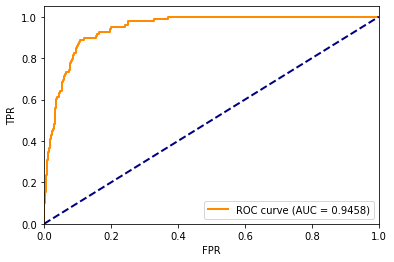

In [14]:
# 실험 1 기준
# min_max normalize 로직 수정 auc: 0.84 -> 0.94
# standardization은 효과 없음(성능 안 좋음 auc=0.64).
# 전처리 없으면 성능 안 좋음
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {})'.format(round(auc(fpr, tpr), 5)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.show()

In [15]:
def select_threshold(fpr, tpr, threshold):
  ret = 0
  standard = (0, 1)
  threshold_distance = 9999999999
  for x, y, th in zip(fpr, tpr, threshold):
    distance = (x-standard[0])**2+(y-standard[1])**2
    if distance < threshold_distance:
      threshold_distance = distance
      ret = th
  return ret

In [16]:
#0 은 정상, 1은 비정상
true_list = []
pred_list = []
test_x = data.test_x
test_y = data.test_y
my_threshold = select_threshold(fpr, tpr, threshold)
for x, y in zip(test_x, test_y):
  x = torch.FloatTensor(x)
  reconstruct_x = engine.model(x)
  loss = engine.loss_fn(reconstruct_x, x)
  if loss.item() < my_threshold:
    pred_list.append(0)
  elif loss.item() >= my_threshold:
    pred_list.append(1)
  if y == [config['normal_num']]:
    true_list.append(0)
  elif y != [config['normal_num']]:
    true_list.append(1)

In [17]:
print(my_threshold)
print(confusion_matrix(true_list, pred_list))
print(classification_report(true_list, pred_list))
idx = 0
fp_list = []
fn_list = []
for t, p in zip(true_list, pred_list):
  if t == 0 and p == 1:
    fn_list.append(idx)
  if t == 1 and p == 0:
    fp_list.append(idx)
  idx +=1

0.0960940346121788
[[875 105]
 [ 11  87]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       980
           1       0.45      0.89      0.60        98

    accuracy                           0.89      1078
   macro avg       0.72      0.89      0.77      1078
weighted avg       0.94      0.89      0.91      1078



loss: 0.10043543577194214 threshold: 0.0960940346121788


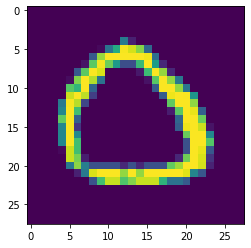

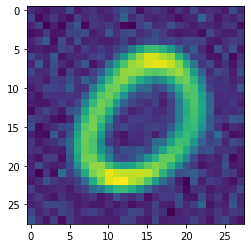


loss: 0.09907068312168121 threshold: 0.0960940346121788


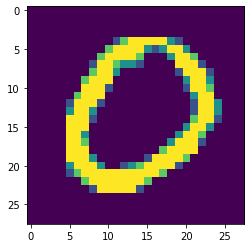

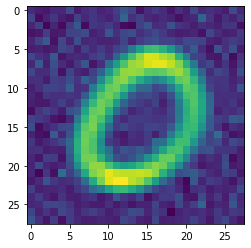

In [18]:
for idx in fn_list[:2]:
  x = data.test_x[idx]
  x = torch.FloatTensor(x)
  represent_x = engine.model(x)
  loss = engine.loss_fn(x, represent_x)
  print("loss: {} threshold: {}".format(loss.item(), my_threshold))
  image_origin = np.array(np.array(data.test_x[idx]).reshape(28, 28)*255, dtype=int)
  image_represent = np.array(represent_x.detach().numpy().reshape(28, 28)*255, dtype=int)
  plt.imshow(image_origin)
  plt.show()
  plt.imshow(image_represent)
  plt.show()
  print()

loss: 0.09142331779003143 threshold: 0.0960940346121788


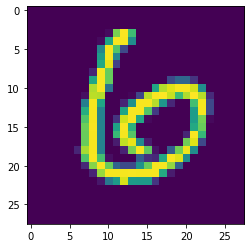

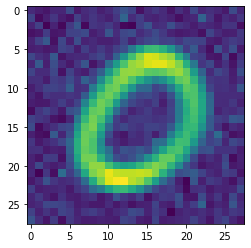


loss: 0.08901352435350418 threshold: 0.0960940346121788


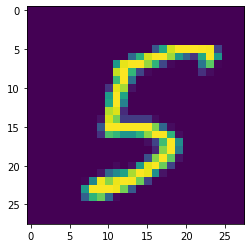

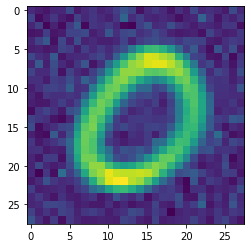

In [19]:
for idx in fp_list[:2]:
  x = data.test_x[idx]
  x = torch.FloatTensor(x)
  represent_x = engine.model(x)
  loss = engine.loss_fn(x, represent_x)
  print("loss: {} threshold: {}".format(loss.item(), my_threshold))
  image_origin = np.array(np.array(data.test_x[idx]).reshape(28, 28)*255, dtype=int)
  image_represent = np.array(represent_x.detach().numpy().reshape(28, 28)*255, dtype=int)
  plt.imshow(image_origin)
  plt.show()
  plt.imshow(image_represent)
  plt.show()
  print()